# Pancreas endocrinogenesis E1415 - scVelo

# Imports and settings

In [3]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import scvelo as scv
import cellrank as cr
import anndata as ad
from cellrank.kernels import ConnectivityKernel, VelocityKernel
from cellrank.estimators import GPCCA

In [4]:
cr.logging.print_versions()

cellrank==1.5.1+g525b847 scanpy==1.9.1 anndata==0.8.0 numpy==1.23.5 numba==0.56.4 scipy==1.10.0 pandas==1.5.2 pygpcca==1.0.4 scikit-learn==1.2.0 statsmodels==0.13.5 scvelo==0.2.5 pygam==0.8.0 matplotlib==3.6.2 seaborn==0.12.2


# Data loading and preprocessing

In [5]:
org_adata = sc.read("/lustre/groups/ml01/workspace/monge_velo/data/benchmarks/gastrulation/adata_gastrulation.h5ad")

leave_out_stage = ['E6.5', 'E6.75', 'E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0']
leave_in_cell = ['Blood progenitors 2', 'Erythroid1', 'Erythroid2', 'Erythroid3']
adata = org_adata[~org_adata.obs["stage"].isin(leave_out_stage)].copy()
adata = adata[adata.obs["celltype"].isin(leave_in_cell)].copy()

map_dict = {"E6.5": 6.5, "E6.75": 6.75, "E7.0": 7.0, "E7.25": 7.25, "E7.5": 7.5, "E7.75": 7.75, "E8.0": 8.0,
            "E8.25": 8.25, "E8.5": 8.5}
adata.obs["stage"] = adata.obs["stage"].copy().map(map_dict)

adata.obs = adata.obs.loc[:, ['stage', 'celltype']]
adata.var = adata.var[[]]

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [6]:
adata_825 = adata[adata.obs['stage'] == 8.25, :].copy()
adata_85 = adata[adata.obs['stage'] == 8.5, :].copy()

In [7]:
sc.pp.pca(adata_825, n_comps=50)
scv.pp.moments(adata_825)
scv.tl.recover_dynamics(adata_825, n_jobs=80)
scv.tl.velocity(adata_825, mode = 'dynamical')

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:13) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 80/96 cores)
or disable the progress bar using `show_progress_bar=False`.


/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:04:47) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [8]:
sc.pp.pca(adata_85, n_comps=50)
scv.pp.moments(adata_85)
scv.tl.recover_dynamics(adata_85, n_jobs=80)
scv.tl.velocity(adata_85, mode = 'dynamical')

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 80/96 cores)


/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:724: VisibleD

    finished (0:04:58) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [9]:
adata = ad.concat([adata_825, adata_85])
sc.pp.neighbors(adata)
adata

AnnData object with n_obs × n_vars = 4645 × 53801
    obs: 'stage', 'celltype', 'n_counts'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
    obsp: 'distances', 'connectivities'

# Precomputed data

In [4]:
adata = sc.read("/home/icb/jonas.flor/precomputed_data/scvelo_branch_gast_pre.h5ad")
adata

AnnData object with n_obs × n_vars = 4645 × 53801
    obs: 'stage', 'celltype', 'n_counts'
    uns: 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

# Alternative data

In [15]:
adata = scv.datasets.gastrulation_erythroid()

leave_out_stage = ['E6.5', 'E6.75', 'E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0']
leave_in_cell = ['Blood progenitors 2', 'Erythroid1', 'Erythroid2', 'Erythroid3']
adata = adata[~adata.obs["stage"].isin(leave_out_stage)].copy()
adata = adata[adata.obs["celltype"].isin(leave_in_cell)].copy()

map_dict = {"E6.5": 6.5, "E6.75": 6.75, "E7.0": 7.0, "E7.25": 7.25, "E7.5": 7.5, "E7.75": 7.75, "E8.0": 8.0,
            "E8.25": 8.25, "E8.5": 8.5}
adata.obs["stage"] = adata.obs["stage"].copy().map(map_dict)

adata.obs = adata.obs.loc[:, ['stage', 'celltype']]
adata.var = adata.var[[]]

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

adata_825 = adata[adata.obs['stage'] == 8.25, :].copy()
adata_85 = adata[adata.obs['stage'] == 8.5, :].copy()

sc.pp.pca(adata_825, n_comps=50)
scv.pp.moments(adata_825)
scv.tl.recover_dynamics(adata_825, n_jobs=80)
scv.tl.velocity(adata_825, mode = 'dynamical')

sc.pp.pca(adata_85, n_comps=50)
scv.pp.moments(adata_85)
scv.tl.recover_dynamics(adata_85, n_jobs=80)
scv.tl.velocity(adata_85, mode = 'dynamical')

adata = ad.concat([adata_825, adata_85])
sc.pp.neighbors(adata)
scv.tl.umap(adata)
adata

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 80/96 cores)


/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:03:47) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 80/96 cores)


/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:05:08) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


AnnData object with n_obs × n_vars = 4645 × 53801
    obs: 'stage', 'celltype', 'n_counts'
    uns: 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
    obsp: 'distances', 'connectivities'

# Transition probabilities

In [11]:
vk = VelocityKernel(adata).compute_transition_matrix()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4645/4645 [00:02<00:00, 2205.54cell/s]


# Macrostate calculation

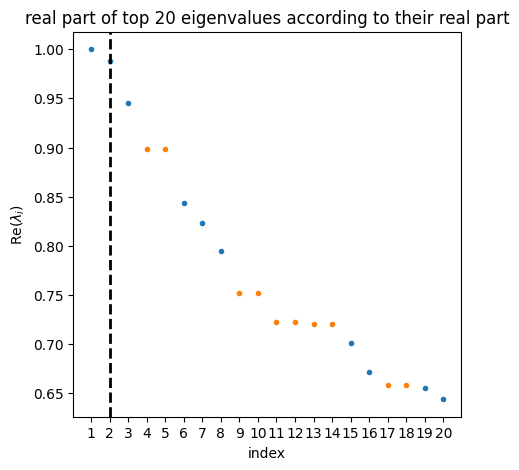

In [12]:
g = GPCCA(vk)
g.compute_schur(n_components=20)
g.plot_spectrum(real_only=True)

/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


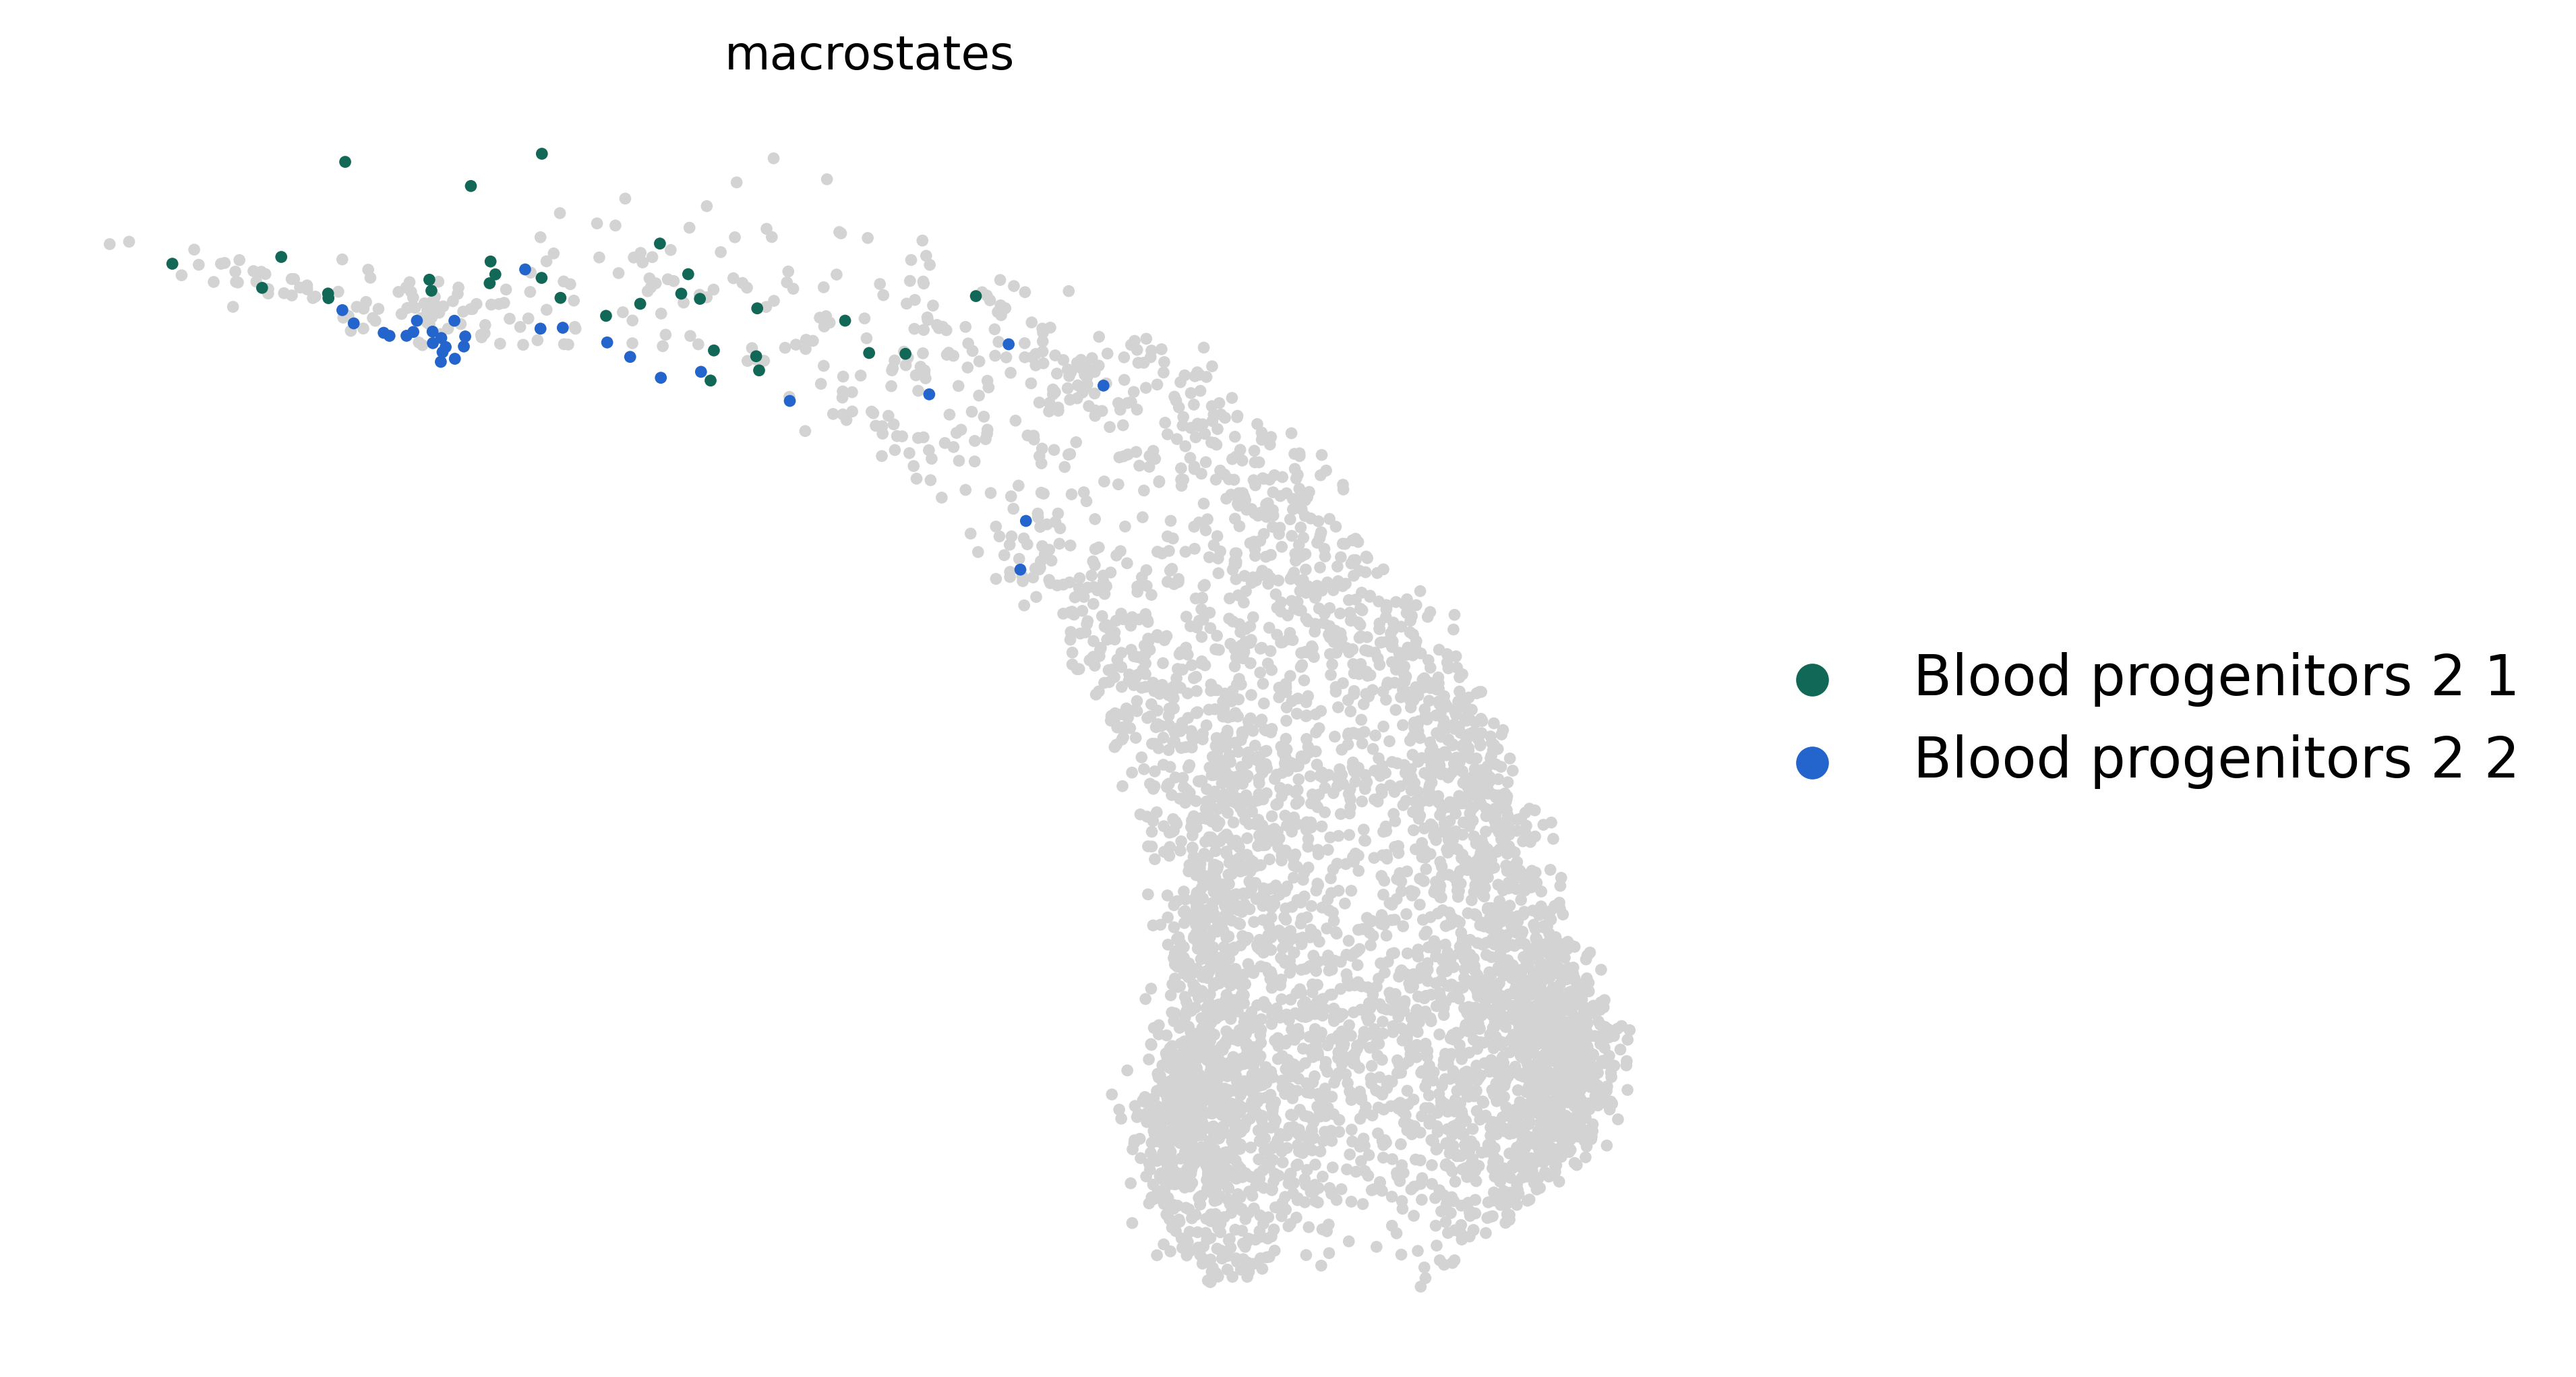

In [13]:
g.compute_macrostates(n_states=2, cluster_key="celltype")
scv.set_figure_params('scvel o', transparent=True, fontsize=20, color_map='viridis')
g.plot_macrostates(discrete=True, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


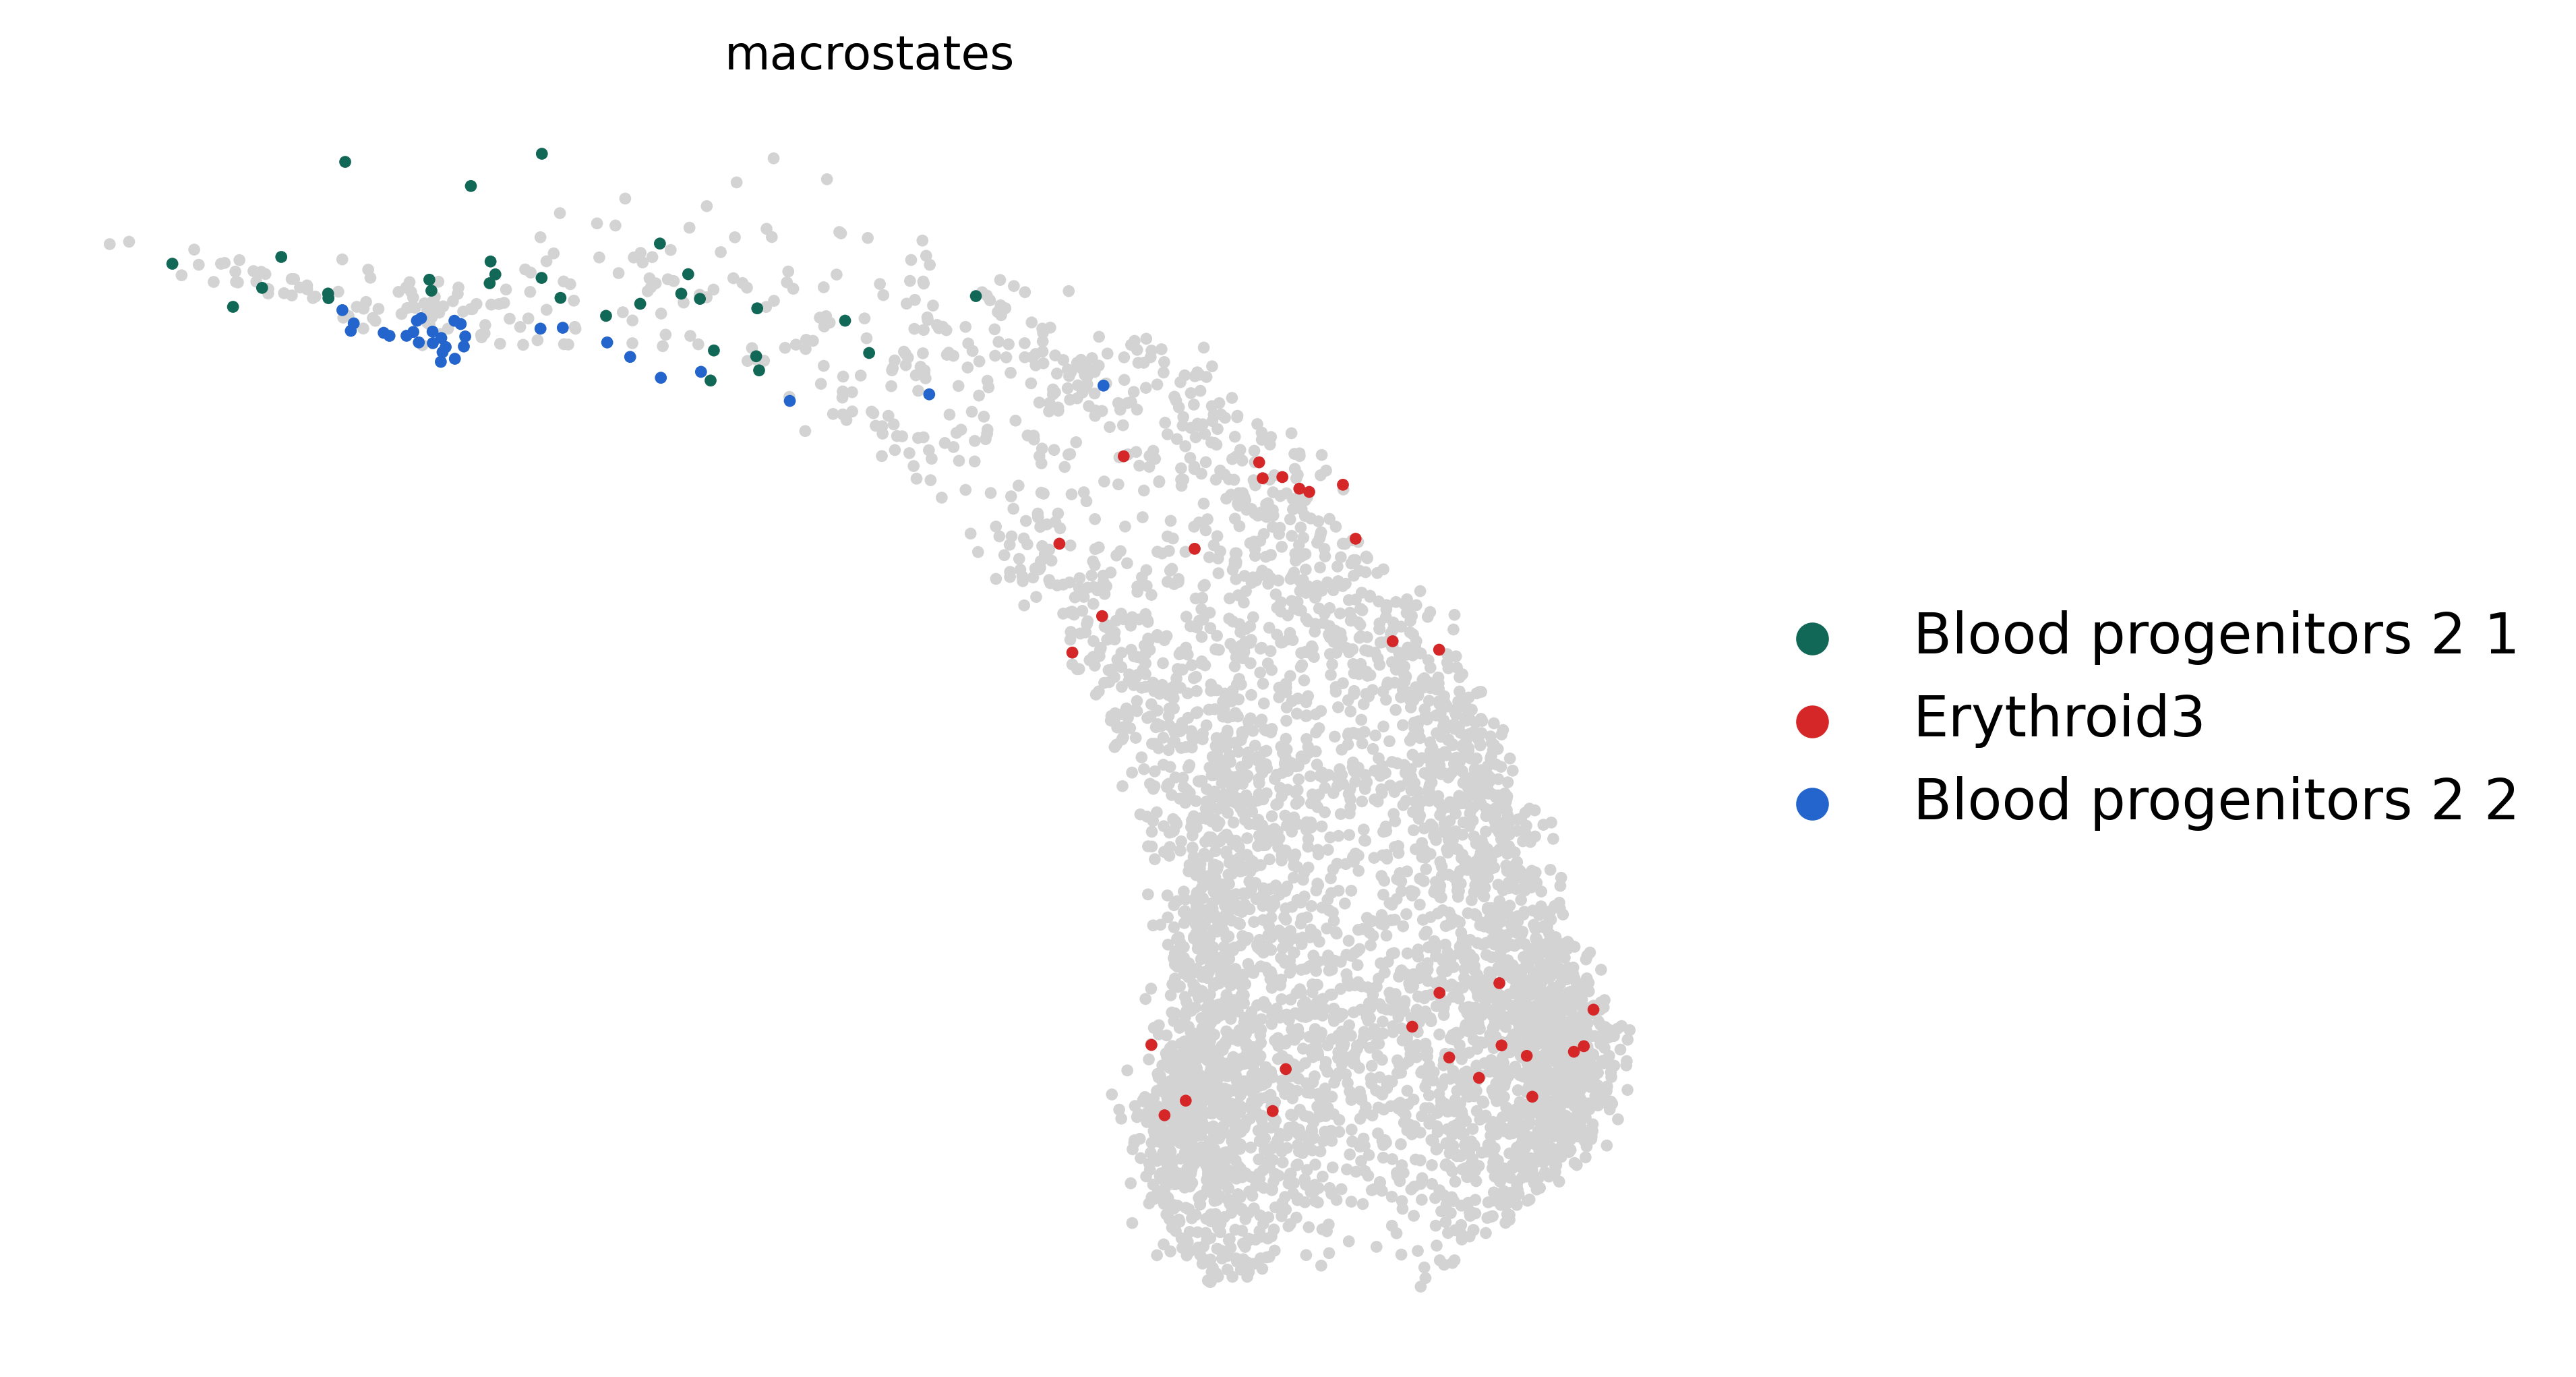

In [14]:
g.compute_macrostates(n_states=3, cluster_key="celltype")
scv.set_figure_params('scvel o', transparent=True, fontsize=20, color_map='viridis')
g.plot_macrostates(discrete=True, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

# Fate probabilities

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.19/s]
/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


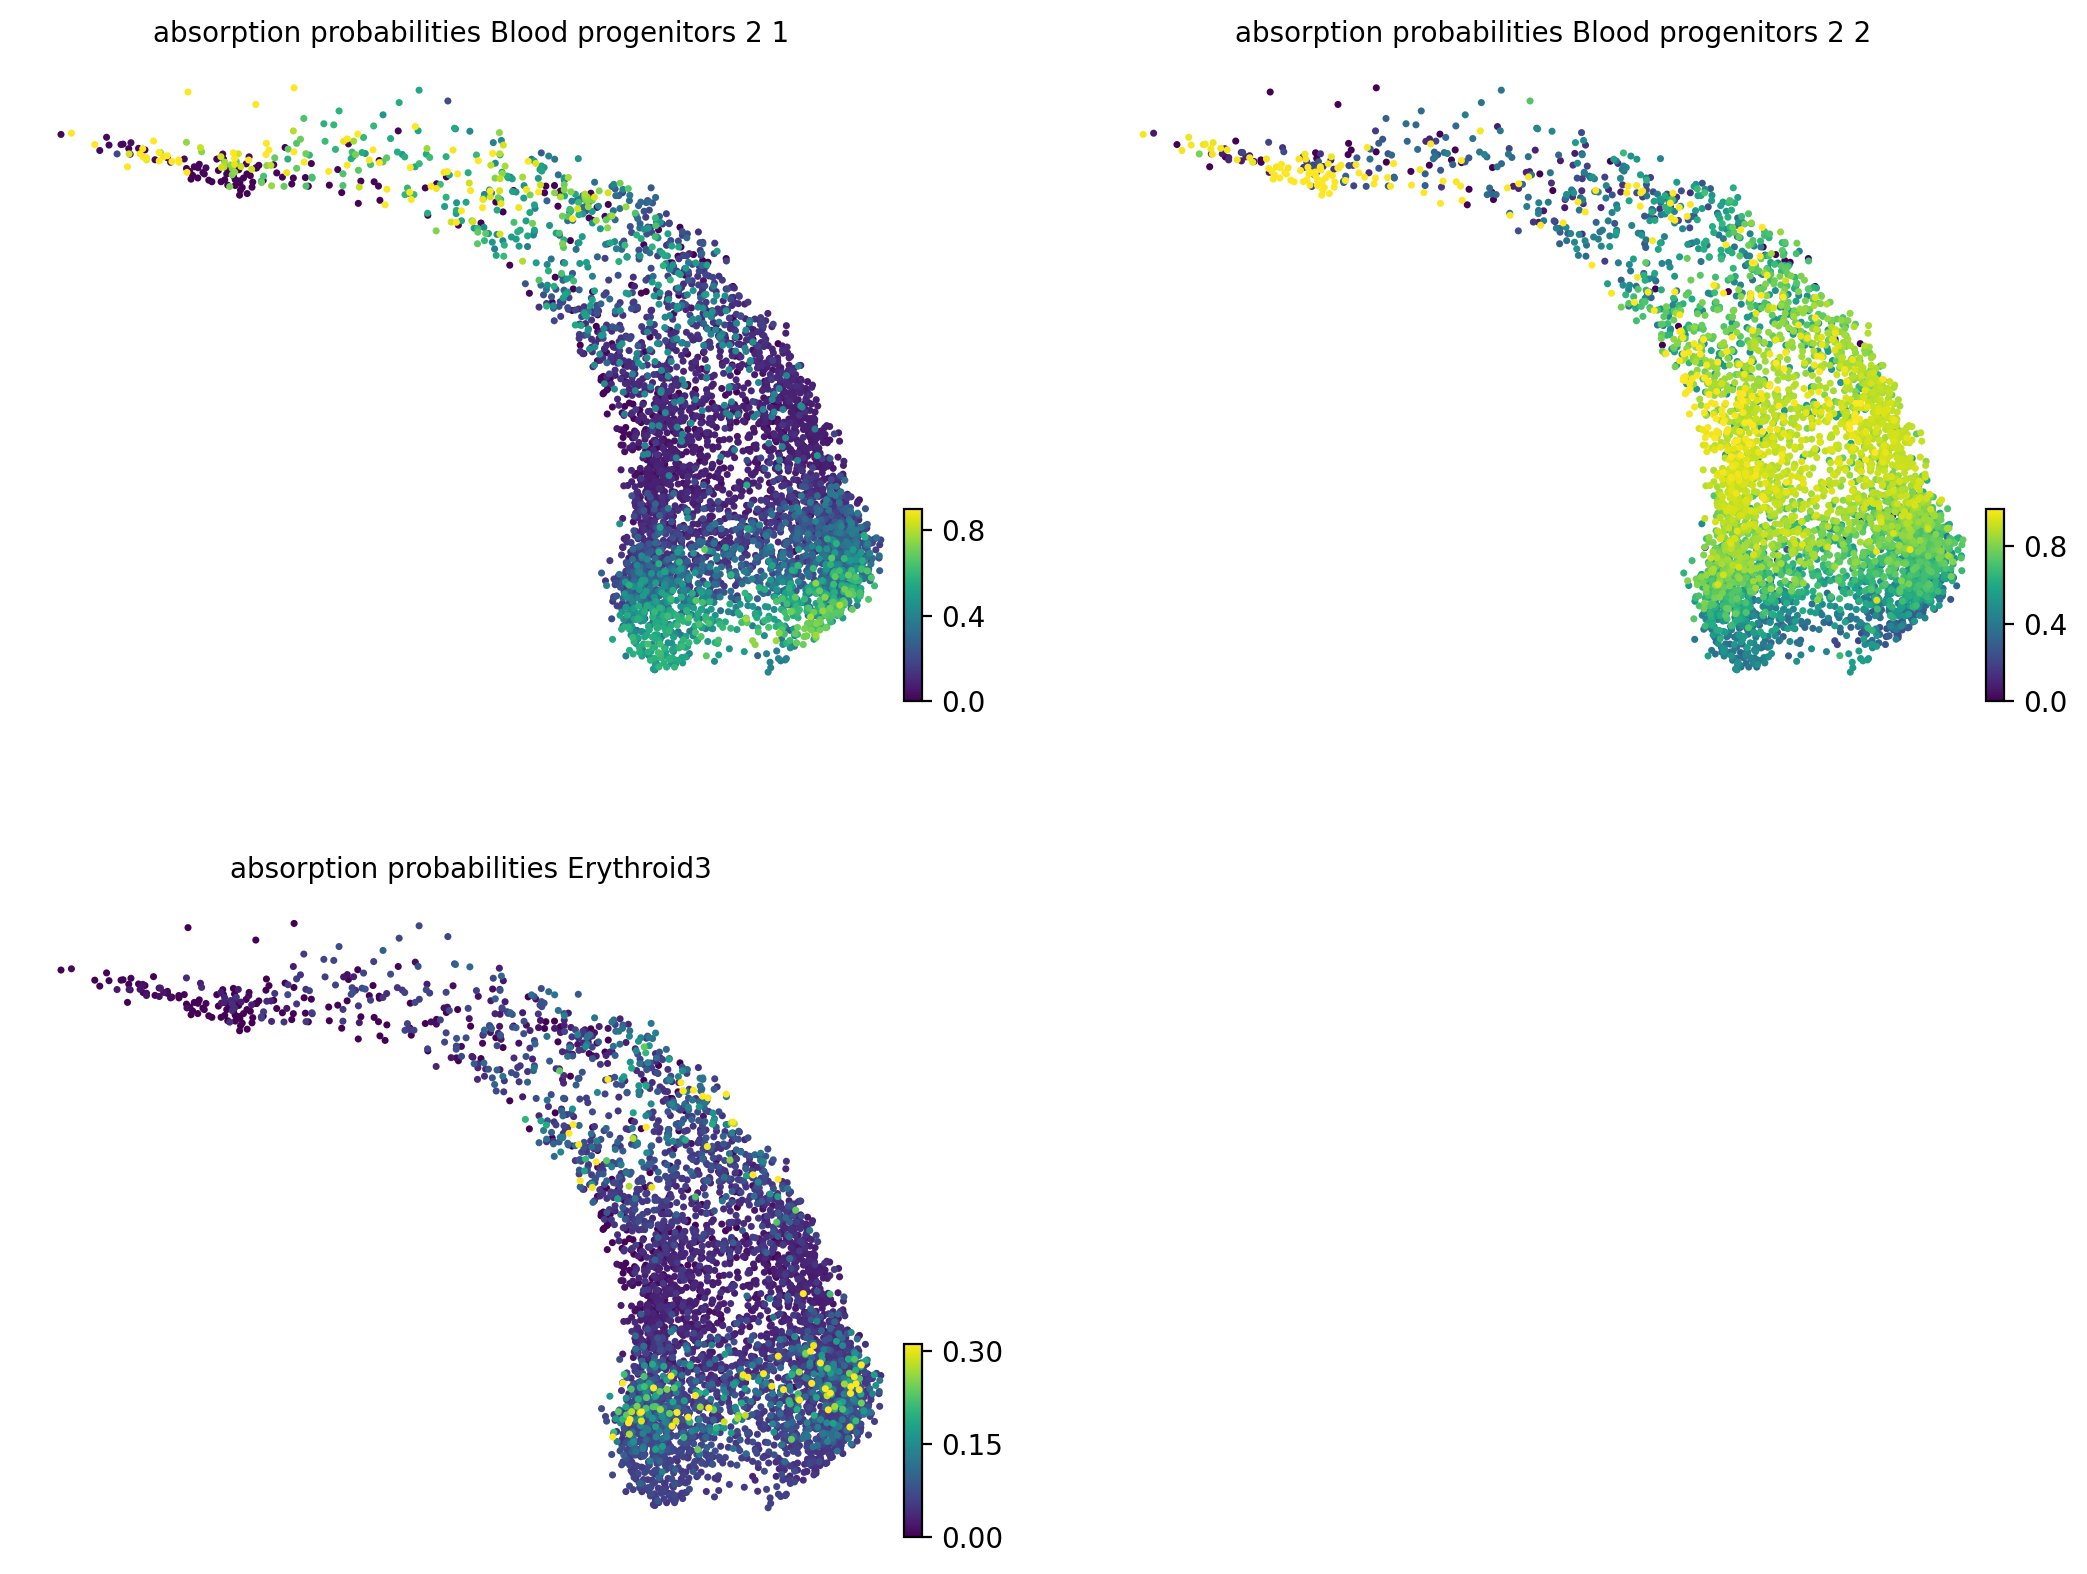

In [15]:
g.set_terminal_states_from_macrostates(
    [
        'Blood progenitors 2_1', 'Blood progenitors 2_2', 'Erythroid3' 
    ]
)
g.compute_absorption_probabilities(solver="gmres", use_petsc=True, tol=1e-12, preconditioner='ilu')
g.plot_absorption_probabilities(same_plot=False, basis="umap", perc=[0, 99], ncols=2)

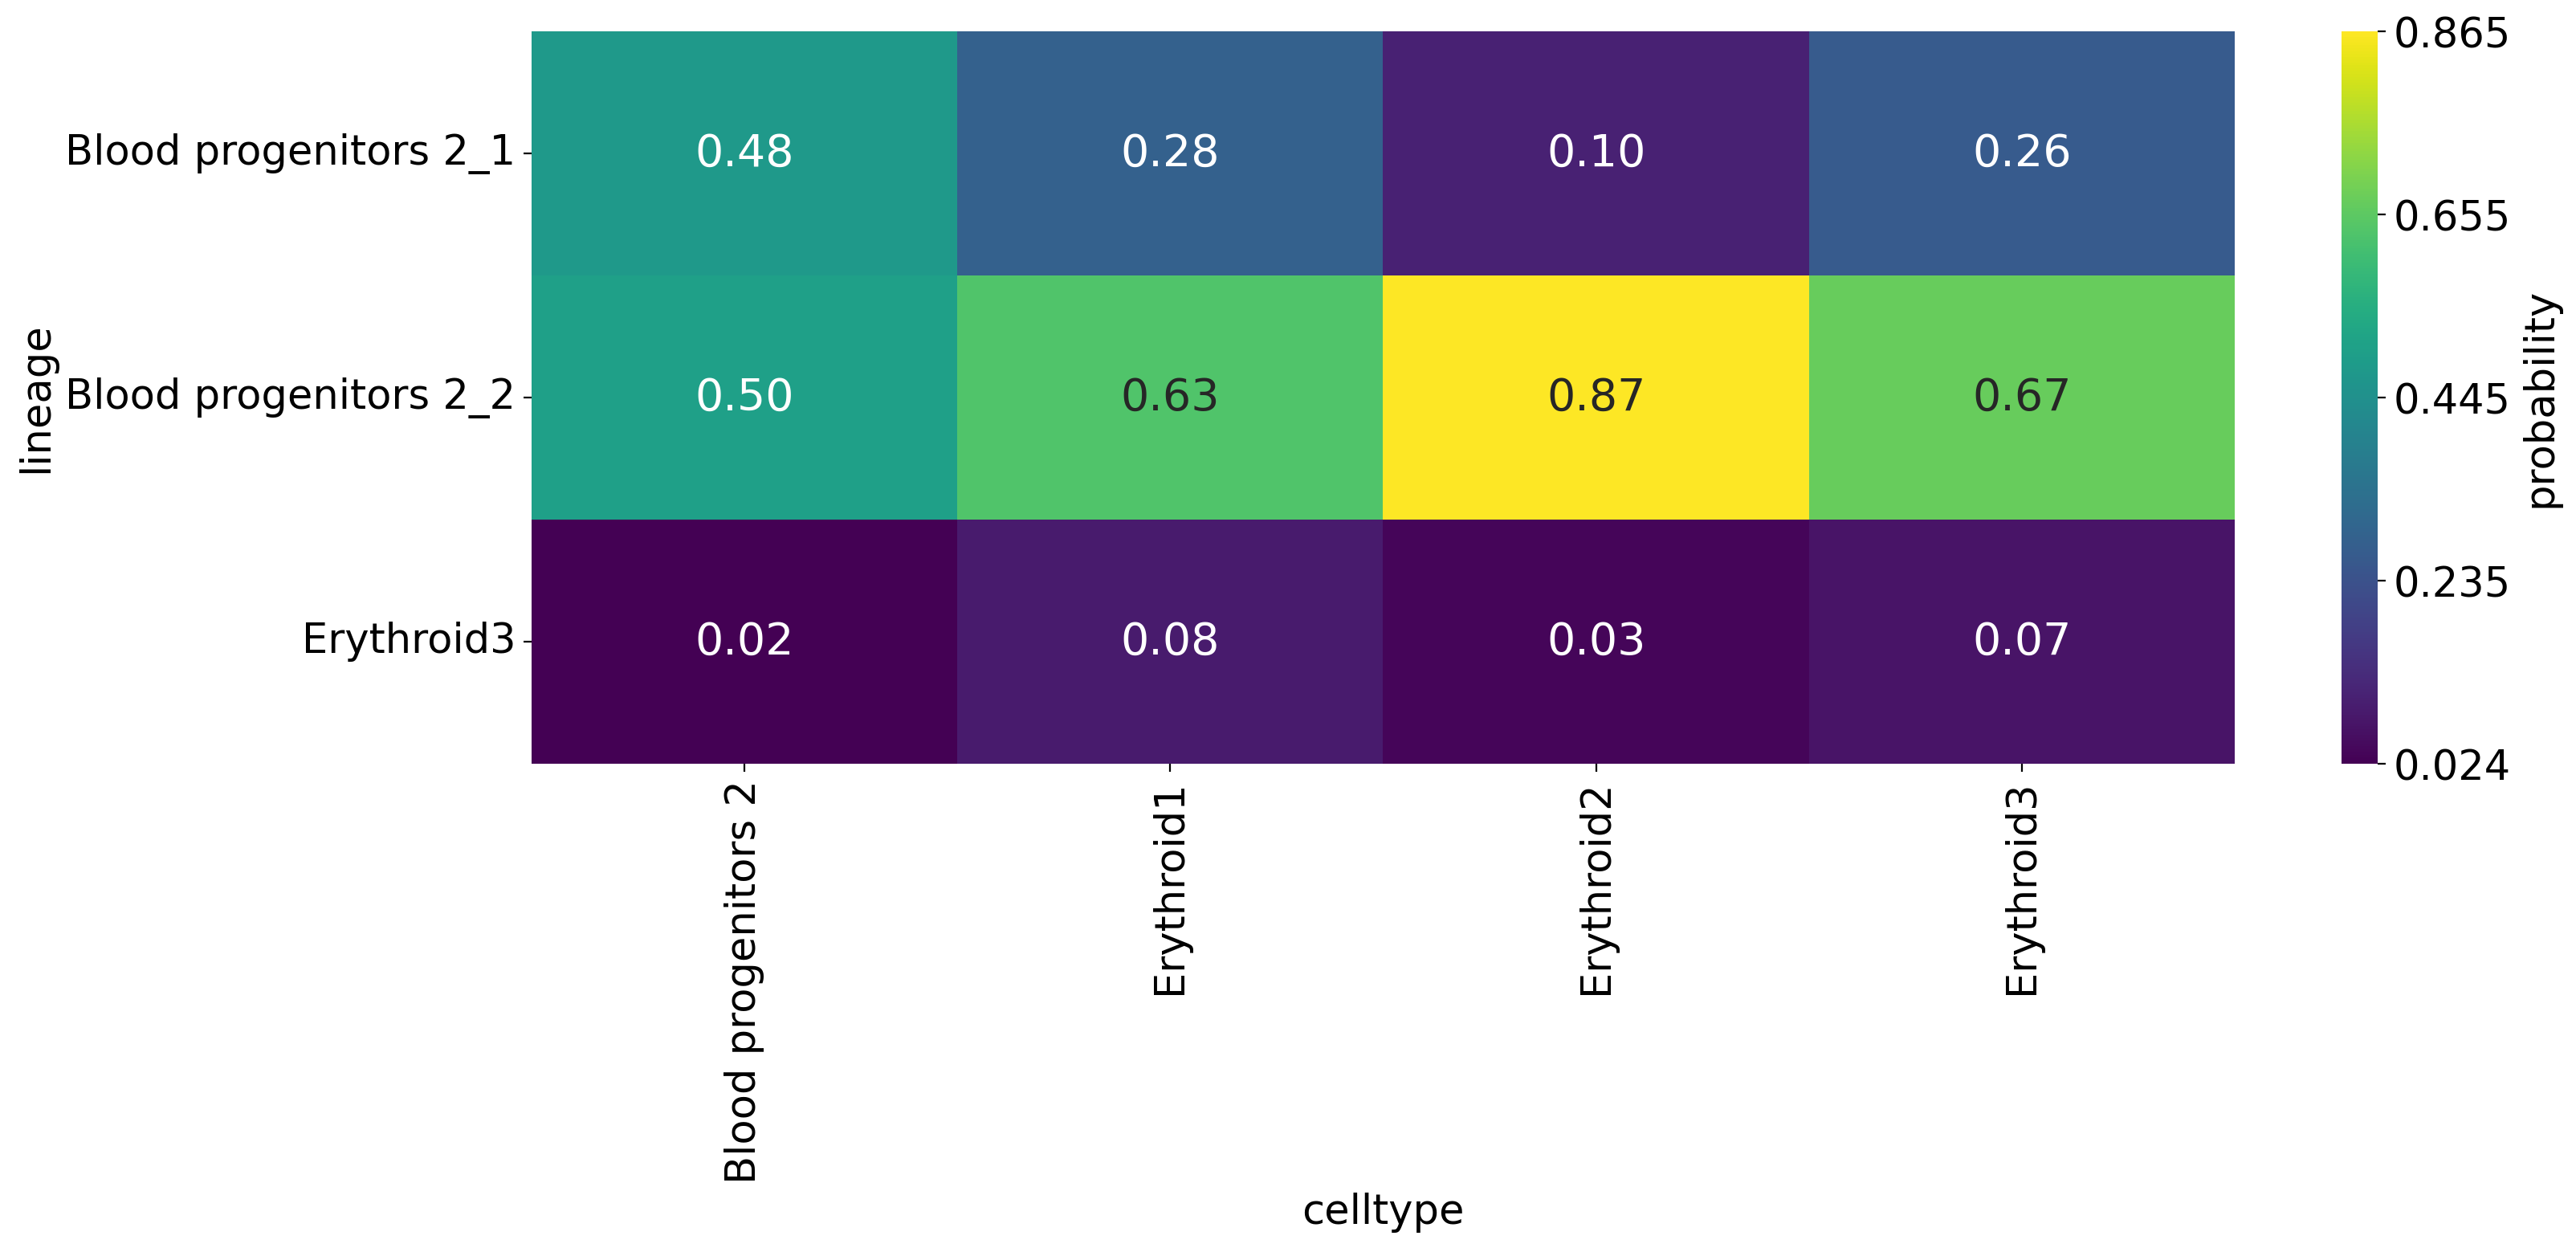

In [16]:
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')
cr.pl.aggregate_absorption_probabilities(
    adata,
    mode='heatmap',
    lineages=['Blood progenitors 2_1', 'Blood progenitors 2_2', 'Erythroid3'],
    cluster_key='celltype',
    clusters=['Blood progenitors 2', 'Erythroid1', 'Erythroid2', 'Erythroid3'],
    figsize=(17, 6),
    title="",
    #save="transprobs_pancreas1415_scvelo.png"
)

In [17]:
cluster = ['Blood progenitors 2', 'Erythroid1', 'Erythroid2', 'Erythroid3']
terminal_cluster = ['Blood progenitors 2_1', 'Blood progenitors 2_2', 'Erythroid3']

aggregated_absorption_prob = np.empty((len(terminal_cluster), len(cluster)))
data = g.absorption_probabilities.X
sums = np.sum(data, axis=0)
tmp = adata.obs['celltype']

for i in range(len(cluster)):
    aggregated_absorption_prob[:,i] = np.dot(np.array((tmp.array==cluster[i]).astype(int)),data)
for i in range(len(cluster)):
    aggregated_absorption_prob[:,i] = aggregated_absorption_prob[:,i]/np.sum(aggregated_absorption_prob[:,i])
df = pd.DataFrame(aggregated_absorption_prob)
df.index = terminal_cluster
df.columns = cluster

In [18]:
correct_transitions = [('Erythroid3', 'Blood progenitors 2'), ('Erythroid3', 'Erythroid1'),
                       ('Erythroid3', 'Erythroid2'), ('Erythroid3', 'Erythroid3')]

sum_prob = 0
for i in correct_transitions:
    sum_prob = sum_prob + df.loc[i]
mean_prob = sum_prob/len(cluster)
mean_prob

0.05329870438049375

# Velocity stream plot

computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


<Figure size 600x400 with 0 Axes>

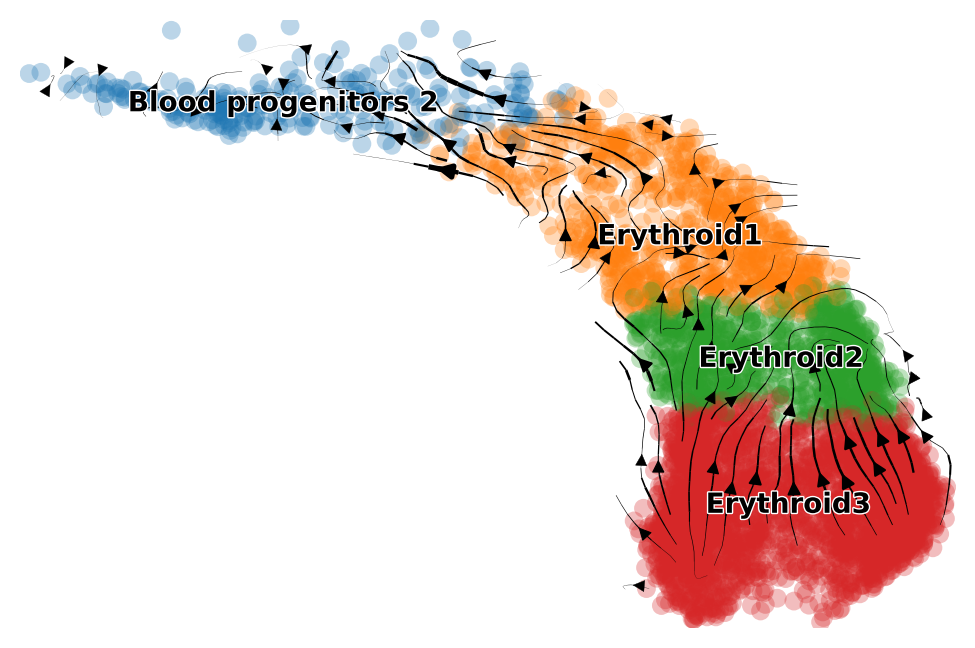

In [19]:
adata.uns["velocity_graph"] = vk.transition_matrix

scv.set_figure_params('scvelo', transparent=True, fontsize=10, dpi_save=400,color_map='viridis')
fig = plt.figure()
ax = scv.pl.velocity_embedding_stream(adata, basis="umap", smooth=0.5, title="", color='celltype')#, legend_loc="none", show=False)
#legend =ax.legend(bbox_to_anchor=[1.25, 1.5], loc='upper center', ncol=6,frameon=True, prop={'size': 18})

In [20]:
scv.tl.velocity_confidence(adata)

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


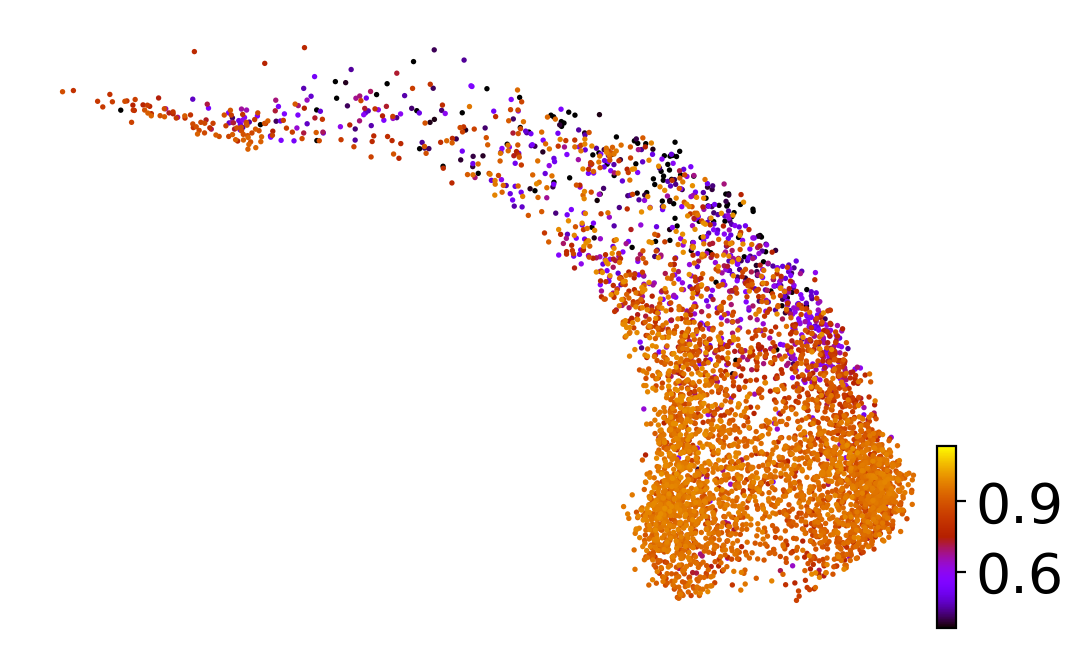

In [21]:
scv.set_figure_params('scvelo', fontsize=20)
scv.settings.presenter_view = False
scv.pl.scatter(adata, color='velocity_confidence',
               perc=[2, 98],
               cmap='gnuplot',
               vmid=0.75,
               rescale_color=[0.5, 1.0],
               size=15,
               title="",
               #save="velconf_pancreas1415_scvelo.png"
              )

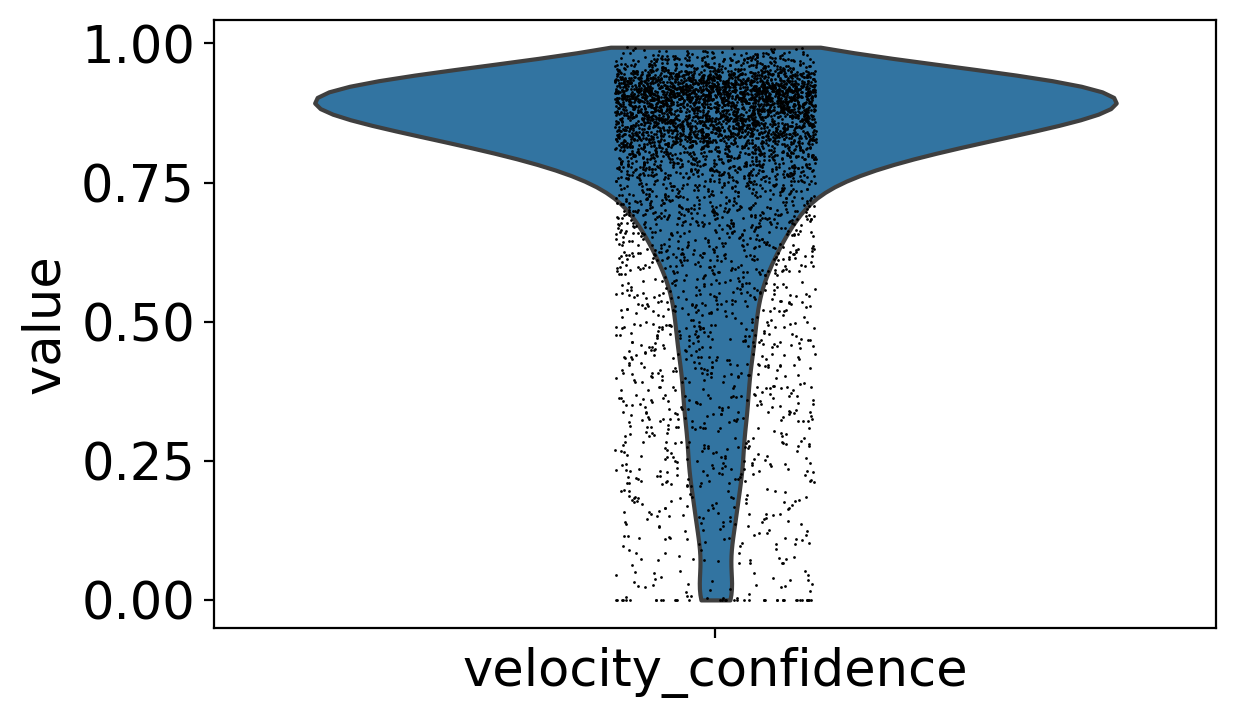

In [22]:
sc.pl.violin(adata, keys='velocity_confidence')

# Umap

/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


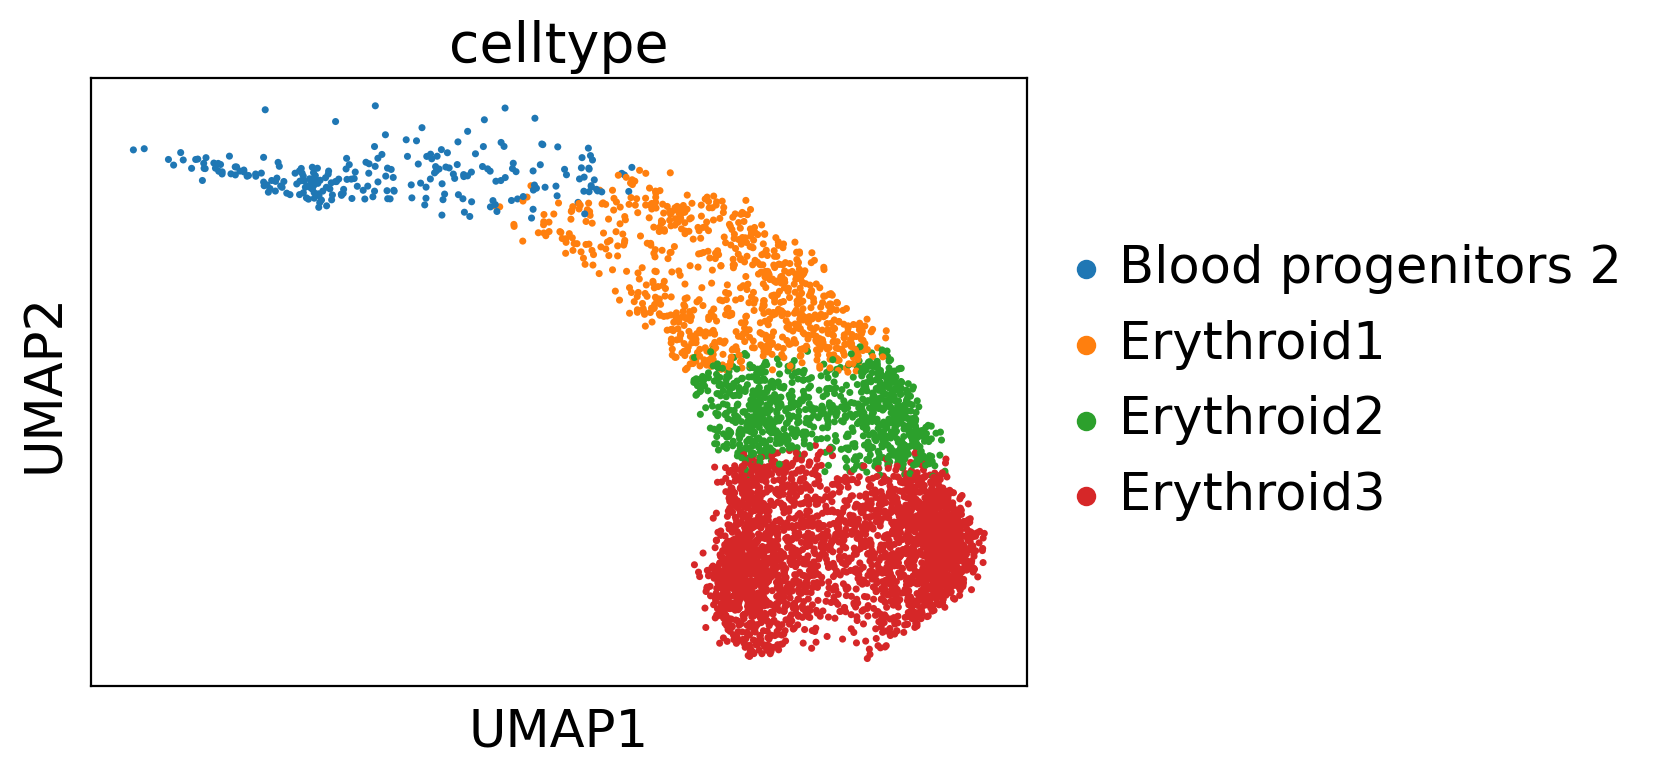

In [23]:
sc.pl.umap(adata, color='celltype')